In [1]:
import os
os.chdir('/nfs/pic.es/user/m/mbilkis/cdisc')
import sys
sys.path.insert(0, os.getcwd())

import numpy as np
from numerics.utilities.misc import *
import pickle
import numpy as np
from tqdm import tqdm
import argparse



In [6]:
Ntraj = 1000
omega0, omega1 = 1e4, 1.05e4
omega0, omega1 = 1e4, 1.1e4

omega_pro = (omega0 + omega1)/2
period = (2*np.pi/omega_pro)
dt = period/100
total_time = 200*period
exp_path = "freqs/{}/".format([omega0,omega1])
save_path = get_path_config(exp_path=exp_path,total_time=total_time, dt=dt, noitraj=True)
os.makedirs(save_path, exist_ok=True)


###########################
# ###### LOAD DATA
times = np.arange(0, total_time+ dt, dt )
indis = np.linspace(0,len(times)-1, int(1e4)).astype(int)
timind = [times[k] for k in indis]
indis_range = list(range(len(indis)))


B = 1000
dB = 100
boundsB= np.arange(-B,B+dB,dB)

bpos = boundsB[boundsB>=0]
bneg = boundsB[boundsB<0]


deter, stop = {}, {}
stop["_0"] = {i:[] for i in range(1,Ntraj)}
stop["_1"] = {i:[] for i in range(1,Ntraj)}
deter["h0/h1"] ={indb:[0]*len(indis) for indb in range(len(boundsB))}
deter["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}



def load_traj(itraj, what="logliks.npy", flip_params=0):
    gamma0 = gamma1 = 100
    eta0 = eta1 = 1
    kappa0 = kappa1 = 1e3
    n0 = n1 = 1
    omega0, omega1 = 1e4, 1.05e4
    omega0, omega1 = 1e4, 1.1e4
    

    h0 = [gamma0, omega0, n0, eta0, kappa0]
    h1 = [gamma1, omega1, n1, eta1, kappa1]

    omega_pro = (omega0 + omega1)/2
    period = (2*np.pi/omega_pro)
    dt = period/100
    total_time = 200*period
    if flip_params == 1:
        params = [h0, h1]
    else:
        params = [h1,h0]
    exp_path = str(params)+"/"

    l =load_data(exp_path=exp_path, itraj=itraj, total_time=total_time, dt=dt, what=what)
    return l

l1t, l0t = [],[]
n=1
ers = []
for itraj in tqdm(range(1,Ntraj)):
    try:

        [l0_1,l1_1], [l1_0,l0_0] = load_traj(itraj=itraj,what="logliks.npy", flip_params=0).T, load_traj(itraj=itraj,what="logliks.npy", flip_params=1).T
        log_lik_ratio, log_lik_ratio_swap = l1_1-l0_1, l1_0-l0_0

        l1t.append(log_lik_ratio[::100])
        l0t.append(log_lik_ratio_swap[::100])
        
        for indb,b in enumerate(boundsB):
            deter["h0/h1"][indb] += ((log_lik_ratio[indis_range] < b).astype(int)  - deter["h0/h1"][indb])/n
            deter["h1/h0"][indb] += ((log_lik_ratio_swap[indis_range] > b).astype(int)  - deter["h1/h0"][indb])/n
            if b>=0:
                stop["_1"][itraj].append(get_stop_time(log_lik_ratio, b, timind))
                stop["_0"][itraj].append(get_stop_time(log_lik_ratio_swap, b,timind))
        n+=1
    except Exception:
        ers.append(itraj)
        print("error {}".format(itraj))
        
        

alphas = list(deter["h1/h0"].values())
betas = list(deter["h0/h1"].values())

alphas = np.stack(alphas)
betas = np.stack(betas)

avg_err= lambda b: (1-np.exp(-abs(b)))/(np.exp(abs(b)) - np.exp(-abs(b)))

errs_bound = np.array([avg_err(b) for b in bpos])
tot_err = 0.5*(alphas+betas)

symmetric = tot_err[np.argmin(np.abs(boundsB)),:]
times_to_errs_det = np.array([timind[np.argmin(np.abs(symmetric - bound_err))] for bound_err in errs_bound])



stops0 = [[] for k in range(len(bpos))]
stops1 = [[] for k in range(len(bpos))]

values1 = list(stop["_1"].values())
values0 = list(stop["_0"].values())
for k,val in enumerate(values1):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values1[k][indb]])[0] == True:
                stops1[indb].append(np.squeeze(values1[k][indb]))#

for k,val in enumerate(values0):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values0[k][indb]])[0] == True:
                stops0[indb].append(np.squeeze(values0[k][indb]))


### sequential test
avg_times1 = np.array([np.mean(k) for k in stops1])
avg_times0 = np.array([np.mean(k) for k in stops0])

times_sequential = 0.5*(avg_times0 + avg_times1)


path_data = save_path+"B{}_db{}_{}/".format(B,dB,Ntraj)
os.makedirs(path_data,exist_ok=True)

with open(path_data+"stop.pickle","wb") as g:
    pickle.dump(stop, g, protocol=pickle.HIGHEST_PROTOCOL)

with open(path_data+"deter.pickle","wb") as f:
    pickle.dump(deter, f, protocol=pickle.HIGHEST_PROTOCOL)

np.save(path_data+"times_to_err_det",times_to_errs_det)
np.save(path_data+"times_to_err_stoch",times_sequential)


np.save(path_data+"ll0",np.stack(l0t))
np.save(path_data+"ll1",np.stack(l1t))

print("data saved in {}\n".format(path_data))


100%|██████████| 999/999 [00:41<00:00, 24.24it/s]
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in double_scalars
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: overflow encountered in exp


data saved in /data/uab-giq/scratch/matias/quantera/trajectories/mechanical_freq/freqs/[10000.0, 11000.0]//T_0.11967972013675401_dt_5.9839860068377e-06/B1000_db100_1000/



/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
import matplotlib.pyplot as plt 

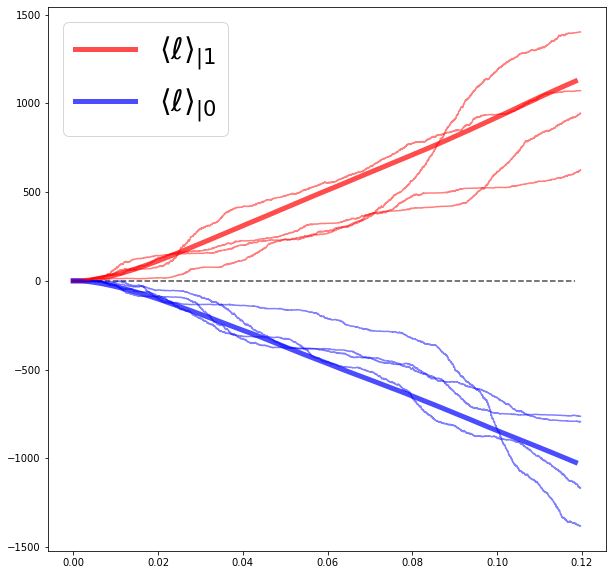

In [5]:
plt.figure(figsize=(10,10))
ax=plt.subplot()
timindt = timind[::100]
ax.plot(timindt,np.mean(l1t,axis=0),color="red", alpha=.7, linewidth=5,label=r'$\langle\ell\rangle_{|1}$')
ax.plot(timindt,np.mean(l0t,axis=0),color="blue", alpha=.7, linewidth=5,label=r'$\langle\ell\rangle_{|0}$')
ax.plot(timindt,0.*np.mean(l0t,axis=0),'--',color="black", alpha=.7)#, linewidth=2#,label="0")

for itraj in range(1,5):
    [l0_1,l1_1], [l1_0,l0_0] = load_traj(itraj=itraj,what="logliks.npy", flip_params=0).T, load_traj(itraj=itraj,what="logliks.npy", flip_params=1).T
    log_lik_ratio, log_lik_ratio_swap = l1_1-l0_1, l1_0-l0_0
    ax.plot(timind,log_lik_ratio,alpha=.5, color="red")
    ax.plot(timind,log_lik_ratio_swap, alpha=.5, color="blue")   
ax.legend(prop={"size":30})

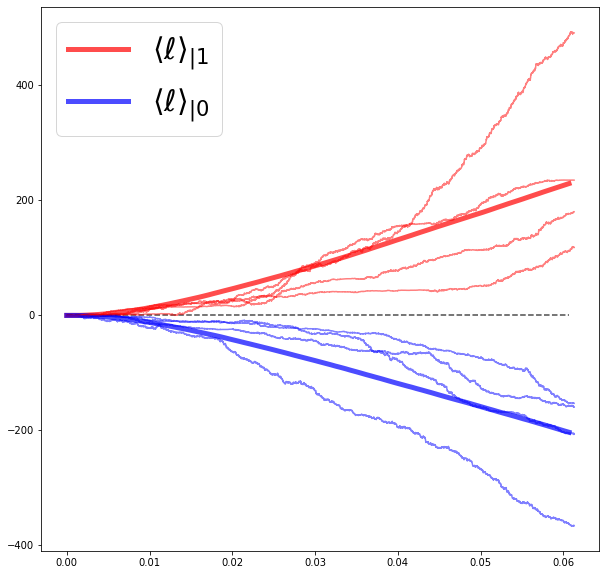

In [4]:
plt.figure(figsize=(10,10))
ax=plt.subplot()
timindt = timind[::100]
ax.plot(timindt,np.mean(l1t,axis=0),color="red", alpha=.7, linewidth=5,label=r'$\langle\ell\rangle_{|1}$')
ax.plot(timindt,np.mean(l0t,axis=0),color="blue", alpha=.7, linewidth=5,label=r'$\langle\ell\rangle_{|0}$')
ax.plot(timindt,0.*np.mean(l0t,axis=0),'--',color="black", alpha=.7)#, linewidth=2#,label="0")

for itraj in range(1,5):
    [l0_1,l1_1], [l1_0,l0_0] = load_traj(itraj=itraj,what="logliks.npy", flip_params=0).T, load_traj(itraj=itraj,what="logliks.npy", flip_params=1).T
    log_lik_ratio, log_lik_ratio_swap = l1_1-l0_1, l1_0-l0_0
    ax.plot(timind,log_lik_ratio,alpha=.5, color="red")
    ax.plot(timind,log_lik_ratio_swap, alpha=.5, color="blue")   
ax.legend(prop={"size":30})

In [ ]:
ana_wald1 = np.array([(np.array([b*(1-beta_seq(b)) -b*(alpha_seq(b)) for b in bpos])/mu1) for mu1 in mu1s])
ana_wald0 = np.array([(np.array([-b*(alpha_seq(b)) +b*(1-alpha_seq(b)) for b in bpos])/mu0) for mu0 in mu0s])


def dete_alpha(t, b, mu,sigma):
    inside = (b + mu*t)/(np.sqrt(2*t*sigma**2))
    return (1 -  erf(inside))/2

def dete_beta(t, b, mu,sigma):
    inside = (b - mu*t)/(np.sqrt(2*t*sigma**2))
    return (1 +  erf(inside))/2
